# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch, gc
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import time
from PIL import Image
import copy
import workspace_utils
from collections import OrderedDict

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
print(device)


cuda


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [3]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [4]:
def dataloader(image_size = (64,64),
               data_dir= "" , batch_size = 32):

# TODO: Define your transforms for the training, validation, and testing sets

    data_train_transforms = transforms.Compose([transforms.Resize(image_size),
                                                transforms.RandomRotation(20),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.RandomVerticalFlip(),
                                                transforms.ToTensor(),
                                                transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
                                                ])


    data_valid_transforms = transforms.Compose([transforms.Resize(image_size),
                                                transforms.CenterCrop(image_size),
                                                transforms.ToTensor(),
                                                transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
                                                ])

# TODO: Load the datasets with ImageFolder
    if data_dir == "":
        data_dir = 'flowers'
        train_dir = data_dir + '/train'
        valid_dir = data_dir + '/valid'
        test_dir = data_dir + '/test'
   
    image_datasets = {}
    image_datasets['train'] = datasets.ImageFolder(train_dir, data_train_transforms)
    image_datasets['valid'] = datasets.ImageFolder(valid_dir, data_valid_transforms)            
    image_datasets['test'] = datasets.ImageFolder(test_dir, data_valid_transforms)
   

    # TODO: Using the image datasets and the trainforms, define the dataloaders

    dataloaders = {}
    dataloaders['train'] = torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers = 0)
    dataloaders['valid'] = torch.utils.data.DataLoader(image_datasets['valid'], batch_size=batch_size, shuffle=True,num_workers = 0)
    dataloaders['test'] = torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=False,num_workers = 0)
    class_names = image_datasets['train'].classes
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
    class_names = image_datasets['train'].classes
    return dataloaders,class_names,dataset_sizes, image_datasets,batch_size,image_size


In [5]:
dataloaders,class_names,dataset_sizes,image_datasets,batch_size,image_size = dataloader(image_size = (224,224))

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [6]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [7]:
model_list = [models.vgg16(pretrained=True), models.resnet18(pretrained=True),models.densenet161(pretrained=True)]

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 99185340.84it/s] 
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 88315160.50it/s]
/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.torch/models/densenet161-8d451a50.pth
100%|██████████| 115730790/115730790 [00:01<00:00, 86743731.66it/s]


In [8]:
def classifier(model,classifier_parameters,dropout = 0.2):
    
    criterion = nn.NLLLoss()
    for param in model.parameters():
        param.requires_grad = False
        
    classifier = nn.Sequential(OrderedDict([
                    ('fc1', nn.Linear(classifier_parameters[0], classifier_parameters[1])),
                    ('relu', nn.ReLU()),
                    ('drop_out', nn.Dropout(p=dropout)),
                    ('fc2', nn.Linear(classifier_parameters[1], classifier_parameters[2])),
                    ('relu', nn.ReLU()),
                    ('drop_out', nn.Dropout(p=dropout)),
                    ('fc3', nn.Linear(classifier_parameters[2], classifier_parameters[3])),
                    ('output', nn.LogSoftmax(dim=1))]))

   
    for param in model.parameters():
        param.requires_grad = False
    model.classifier = classifier
        
    return model, criterion

In [9]:
model,criterion = classifier(model_list[0], [25088, 4096, 512, 102], dropout = 0.1)

optimizer = optim.Adam(model.classifier.parameters(), lr=0.01)

In [10]:
def train_model(model, dataloaders, optimizer,criterion = nn.NLLLoss()
                ,epochs=2, train_losses_history =[], eval_losses_history =[],val_acc_history = [], 
                epoch_counts = 0,stop_num = 10):
    model.to(device)
    start = time.time()
    epoch_counts = 0
    best_acc = 0
    running_loss = 0
    bad_acc_epoch = 0
    
    for epoch in range(epochs):  
        if bad_acc_epoch < stop_num:
        
            epoch_counts += 1
            valid_size = 0
            train_size = 0
            running_corrects = 0
            train_epoch_loss = 0
            valid_epoch_loss = 0
            running_train_loss = 0
            running_valid_loss = 0
    
            for phase in ['train', 'valid']:
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    if phase == 'train':
                        model.train() 
                        # zero the parameter gradients
                        optimizer.zero_grad()
                        # forward
                        with torch.set_grad_enabled(True) :
                            outputs = model(inputs)
                            _, preds = torch.max(outputs, 1)
                            loss = criterion(outputs, labels)
                            loss.backward()
                            optimizer.step()
                            train_size +=1
                            running_train_loss += loss.item()
                            #print("train" + " " + str(loss.item()) +" " + str(running_train_loss)  )


    # eval phase 
                    if phase == "valid":
      
                        model.eval()
                        inputs = inputs.to(device)
                        labels = labels.to(device)
                # forward
                        with torch.set_grad_enabled(False):
                            outputs = model(inputs)
                            _, preds = torch.max(outputs, 1)
                            loss = criterion(outputs, labels)
                            running_valid_loss += loss.item()
                        valid_size +=1
                        running_corrects += torch.sum(preds == labels.data)
                        #print("valid" + " " + str(loss.item()) +" " + str(running_valid_loss))
                
    # print epoch statistics
    
            train_epoch_loss = running_train_loss/len(dataloaders["train"])
            valid_epoch_loss = running_valid_loss/len(dataloaders["valid"])
            epoch_acc = running_corrects.double() / len(dataloaders["valid"].dataset)
    
            print('Epoch : ',epoch+1, '\t', 'train loss :', train_epoch_loss,'\t', 'val loss :', valid_epoch_loss,
          'val acc :', epoch_acc.item())
     
        # copy the best model
            val_acc_history.append(epoch_acc)
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
                bad_acc_epoch = 0
                best_train_losses_history = train_losses_history
                best_eval_losses_history = eval_losses_history
                best_epoch_counts = epoch_counts
            else:
                bad_acc_epoch +=1
            
            train_losses_history.append(train_epoch_loss)
            eval_losses_history.append(valid_epoch_loss)
            
        else:
            break        

    # statistics
    print('Finished Training')
    model.load_state_dict(best_model)
    time_elapsed = time.time() - start
    print(" Traning complete in {:.0f}m {:.0f}s".format(time_elapsed//60, time_elapsed% 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return [model, best_train_losses_history, best_eval_losses_history, val_acc_history, best_epoch_counts]


My code here is grossly overbloated - I've implemented train and valid phases separetly to get the understanding. Probably will refactor later, when it is working right.

In [11]:
from workspace_utils import active_session

with active_session():
    # do long-running work here
    model, train_losses_history, eval_losses_history, val_acc_history, epoch_counts = train_model(model,dataloaders,optimizer, criterion,epochs=1000)

Epoch :  1 	 train loss : 20.018698434131903 	 val loss : 4.651275689785297 val acc : 0.029339853300733496
Epoch :  2 	 train loss : 6.208353768325433 	 val loss : 7.193130034666795 val acc : 0.029339853300733496
Epoch :  3 	 train loss : 6.928147941682397 	 val loss : 4.568521994810838 val acc : 0.034229828850855744
Epoch :  4 	 train loss : 6.4884230264803255 	 val loss : 4.8085605547978325 val acc : 0.035452322738386305
Epoch :  5 	 train loss : 7.845842361450195 	 val loss : 4.63028909609868 val acc : 0.02567237163814181
Epoch :  6 	 train loss : 8.95991378877221 	 val loss : 4.668563732734094 val acc : 0.034229828850855744
Epoch :  7 	 train loss : 9.275735345700893 	 val loss : 4.652845822847807 val acc : 0.02567237163814181
Epoch :  8 	 train loss : 4.5624606900098845 	 val loss : 4.640400483058049 val acc : 0.02567237163814181
Epoch :  9 	 train loss : 5.411109640540146 	 val loss : 4.724881722376897 val acc : 0.034229828850855744
Epoch :  10 	 train loss : 11.921900670121357 	

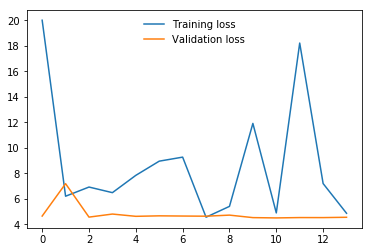

In [12]:
plt.plot(train_losses_history, label='Training loss')
plt.plot(eval_losses_history, label='Validation loss')
plt.legend(frameon=False)
plt.show()

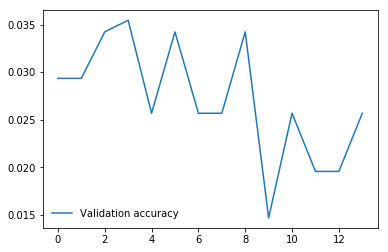

In [13]:
plt.plot(val_acc_history, label='Validation accuracy')
plt.legend(frameon=False)
plt.show()

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [18]:
def testing_model(test_loader, model):
    model.to(device)
    total = 0
    correct = 0
    with torch.no_grad():
        for batch in test_loader:
            
            inputs, expected_labels = batch
            inputs, expected_labels = inputs.to(device), expected_labels.to(device)
            outputs =  model(inputs)

            predicted_labels = torch.argmax(outputs, dim=1)
            total += expected_labels.size(0)

            correct += (predicted_labels == expected_labels).sum().item()
    
    model_accuracy = 100 * correct / total
    return model_accuracy



In [19]:
test_accuracy = testing_model(dataloaders["test"], model)
print('Test acc:  %.1f %%' % test_accuracy)


Test acc:  3.2 %


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [20]:
# saving the model
model.class_to_idx = image_datasets['train'].class_to_idx
checkpoint = {'output_size': 102,
              'epochs': epoch_counts,
              'batch_size': batch_size,
              'model': model,
              'optimizer': optimizer.state_dict(),
              'state_dict': model.state_dict(),
              'class_to_idx': model.class_to_idx,
              'criterion':criterion,
              'history':[train_losses_history, eval_losses_history, val_acc_history]
             }
   
torch.save(checkpoint, 'checkpoint.pth')